# 01-02 : Roberta

## References

- [Fine-tuning Roberta using ktrain](https://www.kaggle.com/code/ashentoaster/fine-tuning-roberta-using-ktrain)
- [MULTI-LABEL CLASSIFICATION USING 🤗 HUGGING FACE TRANSFORMERS AUTOMODELFORSEQUENCECLASSIFICATION](https://www.alexanderjunge.net/blog/til-multi-label-automodelforsequenceclassification/)
- [RoBERTa for Multi-label classification](https://www.kaggle.com/code/piyushrg/roberta-for-multi-label-classification)
- [Text Classification with Hugging Face Transformers in ktrain](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

 ### Interesting Models

- [FacebookAI/roberta-large-mnli](https://huggingface.co/FacebookAI/roberta-large-mnli) - fine-tuned on the Multi-Genre Natural Language Inference (MNLI) corpus.
- [MoritzLaurer/deberta-v3-large-zeroshot-v2.0](https://huggingface.co/MoritzLaurer/deberta-v3-large-zeroshot-v2.0)

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [30]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, jaccard_score, accuracy_score, f1_score

In [3]:
data_path = '../../data'
input_path = f'{data_path}/input/labelled_tweets/csv_labels'
train_input_file = f'{input_path}/train.csv'
test_input_file = f'{input_path}/test.csv'
val_input_file = f'{input_path}/val.csv'

## 1. Load Data

In [4]:
df_train = pd.read_csv(train_input_file)
df_val = pd.read_csv(val_input_file)
df_test = pd.read_csv(test_input_file)

# show the data frame shapes
print(f'Train shape: {df_train.shape}')
print(f'Val shape: {df_val.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (6957, 3)
Val shape: (987, 3)
Test shape: (1977, 3)


In [5]:
df_train.head()

,ID,text,labels
0,1311981051720409089t,"@sandraburgess3 They have no idea , they cant ...",ineffective
1,1361403925845401601t,@stepheniscowboy Nvm I ’ ve had covid I ’ ve g...,unnecessary
2,1293488278361055233t,Coronavirus updates : Government partners with...,pharma
3,1305252218526990338t,@OANN U . K . Glaxo Smith Klein whistleblower ...,rushed
4,1376135683400687618t,"3 / horse "" AstraZeneca , not so much for the ...",ineffective pharma


## 2. Preprocessing

### 2.1. Labels to List

In [6]:
df_train['labels_list'] = df_train['labels'].str.split(' ')
df_test['labels_list'] = df_test['labels'].str.split(' ')
df_val['labels_list'] = df_val['labels'].str.split(' ')

In [7]:
df_train.head()

,ID,text,labels,labels_list
0,1311981051720409089t,"@sandraburgess3 They have no idea , they cant ...",ineffective,[ineffective]
1,1361403925845401601t,@stepheniscowboy Nvm I ’ ve had covid I ’ ve g...,unnecessary,[unnecessary]
2,1293488278361055233t,Coronavirus updates : Government partners with...,pharma,[pharma]
3,1305252218526990338t,@OANN U . K . Glaxo Smith Klein whistleblower ...,rushed,[rushed]
4,1376135683400687618t,"3 / horse "" AstraZeneca , not so much for the ...",ineffective pharma,"[ineffective, pharma]"


### 2.2. Multi-label Binarization

In [8]:
# get the list of label values
labels = pd.concat([df_train.labels_list, 
                    df_val.labels_list, 
                    df_test.labels_list])

# initialize MultiLabelBinarizer
labels_lookup = MultiLabelBinarizer()

# learn the vocabulary
labels_lookup = labels_lookup.fit(labels)

# show the vocabulary
vocab = labels_lookup.classes_
print(f'Vocabulary size: {len(vocab)}')
print(f'Vocabulary: {vocab}')


Vocabulary size: 12
Vocabulary: ['conspiracy' 'country' 'ineffective' 'ingredients' 'mandatory' 'none'
 'pharma' 'political' 'religious' 'rushed' 'side-effect' 'unnecessary']


In [9]:
# update the dataframe with a `labels_encoded` column
df_train['labels_encoded'] = labels_lookup.transform(df_train.labels_list).tolist()
df_val['labels_encoded'] = labels_lookup.transform(df_val.labels_list).tolist()
df_test['labels_encoded'] = labels_lookup.transform(df_test.labels_list).tolist()

In [10]:
df_test.head()

,ID,text,labels,labels_list,labels_encoded
0,1329097028845105155t,@nbc4i Please everyone research Pfizer ’ s his...,pharma,[pharma],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,1340017965828349952t,EVEN WITH A VACCINE IT IS STILL NOT ENOUGH . T...,conspiracy political,"[conspiracy, political]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,1329126491649683459t,@ianbrown @DarrenPlymouth It ’ s the unknown l...,side-effect,[side-effect],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,1285666197003018240t,@FACT_Exeter @K3T3R @respect65 Back to my orig...,rushed,[rushed],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,1284814348679028737t,@DrJasonJohnson IMHO optimistic talk about a v...,ineffective,[ineffective],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [25]:
# add the one-hot encoded labels as columns to the data frames
df_train = df_train.join(pd.DataFrame(labels_lookup.transform(df_train.labels_list), 
                                     columns=labels_lookup.classes_, 
                                     index=df_train.index))

df_val = df_val.join(pd.DataFrame(labels_lookup.transform(df_val.labels_list),
                                    columns=labels_lookup.classes_,
                                    index=df_val.index))

df_test = df_test.join(pd.DataFrame(labels_lookup.transform(df_test.labels_list),
                                    columns=labels_lookup.classes_,
                                    index=df_test.index))

### 2.3. ktrain Text Preparation

In [11]:
model_name = 'FacebookAI/roberta-large'

# create the transformer model
t = text.Transformer(
    model_name=model_name,
    maxlen=512,
    class_names=list(vocab)
)

# preprocess the data
train = t.preprocess_train(df_train.text.values.tolist(), df_train.labels_encoded.values.tolist())
validate = t.preprocess_test(df_val.text.values.tolist(), df_val.labels_encoded.values.tolist())


preprocessing train...
language: en
train sequence lengths:
	mean : 41
	95percentile : 61
	99percentile : 67


Is Multi-Label? True
preprocessing test...
language: en
test sequence lengths:
	mean : 40
	95percentile : 61
	99percentile : 68


## 3. Training

### 3.1. Create Model

In [12]:
 # create the model
model = t.get_classifier()

### 3.2. Create Learner

In [13]:
 # create the learner
learner = ktrain.get_learner(
    model=model, 
    train_data=train,
    val_data=validate,
    batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1159/1159 [==============================] - 621s 497ms/step - loss: 0.3961 - binary_accuracy: 0.8962
Epoch 2/1024
1159/1159 [==============================] - 92s 80ms/step - loss: 2.0835 - binary_accuracy: 0.8455


done.
Visually inspect loss plot and select learning rate associated with falling loss


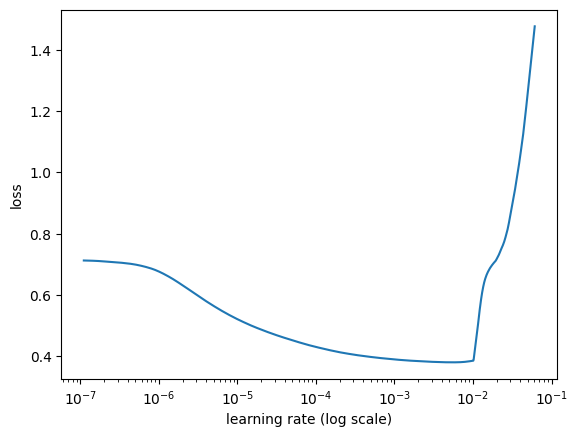

In [14]:
# find best learning rate
learner.lr_find(show_plot=True)

### 3.3. Fit the model

In [15]:
history = learner.autofit(lr=1e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/1024
1160/1160 [==============================] - 628s 510ms/step - loss: 0.2296 - accuracy: 0.5126 - val_loss: 0.1550 - val_accuracy: 0.6727
Epoch 2/1024
1160/1160 [==============================] - 584s 504ms/step - loss: 0.1418 - accuracy: 0.7056 - val_loss: 0.1402 - val_accuracy: 0.6849
Epoch 3/1024
1160/1160 [==============================] - 582s 501ms/step - loss: 0.1143 - accuracy: 0.7516 - val_loss: 0.1410 - val_accuracy: 0.6727
Epoch 4/1024
1160/1160 [==============================] - 582s 502ms/step - loss: 0.0943 - accuracy: 0.7910 - val_loss: 0.1396 - val_accuracy: 0.6849
Epoch 5/1024
1160/1160 [==============================] - 582s 502ms/step - loss: 0.0788 - accuracy: 0.8156 - val_loss: 0.1391 - val_accuracy: 0.6940
Epoch 6/1024
1160/1160 [==============================] - 581s 501

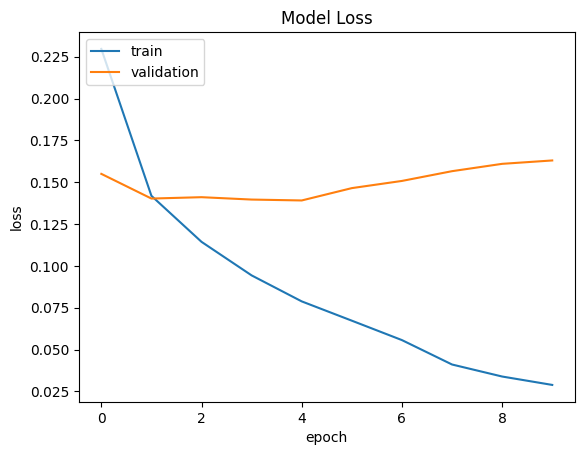

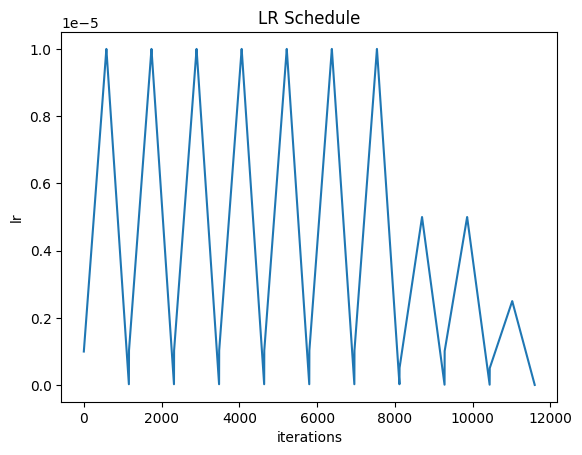

In [18]:
# plot the training history
learner.plot('loss')
learner.plot('lr')

In [19]:
# save the model
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.save('../../models/01-02_roberta_predictor')

## 4. Evaluating the model

In [20]:
class Evaluation:

    @staticmethod
    def f1_score_macro(y_true, y_pred):
        """Calculate F1-score (Macro-Average)."""
        return f1_score(y_true, y_pred, average='macro', zero_division=0)

    @staticmethod
    def f1_score_weighted(y_true, y_pred):
        """Calculate F1-score (Weighted-Average)."""
        return f1_score(y_true, y_pred, average='weighted', zero_division=0)

    @staticmethod
    def jaccard_similarity(y_true, y_pred):
        """Calculate average Jaccard Similarity."""
        return jaccard_score(y_true, y_pred, average='samples')

    @staticmethod
    def subset_accuracy(y_true, y_pred):
        """Calculate Subset Accuracy (Exact Match Accuracy)."""
        return accuracy_score(y_true, y_pred)

    @staticmethod
    def evaluate_all(y_true,
                     y_pred,
                     threshold:float=0.5):
        
        # Convert predictions to binary
        y_pred_bin = [[int(prob > threshold) for label, prob in pred] for pred in y_pred]
        
        """Evaluate all metrics and display a summary."""
        f1_macro = Evaluation.f1_score_macro(y_true, y_pred_bin)
        f1_weighted = Evaluation.f1_score_weighted(y_true, y_pred_bin)
        jaccard_similarity = Evaluation.jaccard_similarity(y_true, y_pred_bin)
        subset_accuracy = Evaluation.subset_accuracy(y_true, y_pred_bin)

        # Display a summary of the evaluation
        print(f"F1 Score (Macro-Average)   \t{f1_macro:.3f}")
        print(f"F1 Score (Weighted-Average)\t{f1_weighted:.3f}")
        print(f"Average Jaccard Similarity \t{jaccard_similarity:.3f}")
        print(f"Subset Accuracy            \t{subset_accuracy:.3f}")

### 4.1. Classification Report

In [21]:
def show_classification_report(data:pd.DataFrame,
                               y_pred:np.ndarray,
                               threshold:float=0.5):
    # get the true labels
    y_true = data[vocab].values
    
    # Convert predictions to binary
    y_pred_bin = [[int(prob > threshold) for label, prob in pred] for pred in y_pred]
    
    # show the classification report
    print(classification_report(y_true, y_pred_bin, target_names=vocab))    

In [27]:
# show the test classification report
y_pred = predictor.predict(df_test.text.values.tolist())
show_classification_report(df_test, y_pred)

              precision    recall  f1-score   support

  conspiracy       0.67      0.48      0.56        97
     country       0.78      0.62      0.69        40
 ineffective       0.74      0.81      0.77       334
 ingredients       0.71      0.70      0.71        87
   mandatory       0.77      0.71      0.74       157
        none       0.62      0.49      0.55       126
      pharma       0.81      0.54      0.65       255
   political       0.71      0.56      0.62       125
   religious       0.64      0.54      0.58        13
      rushed       0.75      0.80      0.77       295
 side-effect       0.86      0.83      0.85       762
 unnecessary       0.71      0.48      0.57       145

   micro avg       0.78      0.71      0.74      2436
   macro avg       0.73      0.63      0.67      2436
weighted avg       0.78      0.71      0.74      2436
 samples avg       0.77      0.74      0.74      2436



/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.2 Full Report 

In [28]:
y_true = df_test[vocab].values
y_pred = predictor.predict(df_test.text.values.tolist())

In [31]:
Evaluation.evaluate_all(y_true, y_pred)

F1 Score (Macro-Average)   	0.673
F1 Score (Weighted-Average)	0.737
Average Jaccard Similarity 	0.704
Subset Accuracy            	0.610
